<h>概要</h>
<p>e-Statは、日本の統計が閲覧できる政府統計ポータルサイトです。e-stat apiから取得したデータは大きく、gcsの料金が大きくなる可能性があると考えたため、先にそのデータを VSCODEを活用してフィルタリングしスモールサイジングした後、gcsにロードする。その後、ETL(グラフ)を行い、githubにアップロードを実施する。

今回のデータは国勢調査のデータを活用します。
特に、テーマにこだわりは無く、e-stat apiからpythonを活用した、データ取得、gcsへのアップロード、vscode活用、etl、githubへのアップロードまで出来ることをアピールしたいと考えました。
<データ概要>
日本に住んでいるすべての人と世帯を対象とする国の最も重要な統計調査で、５年ごとに実施されます。
国勢調査では、年齢別の人口、家族構成、働いている人や日本に住んでいる外国人などの結果を提供しています。
</p>

<p>https://www.e-stat.go.jp/stat-search/database?page=1&layout=datalist&toukei=00200521&tstat=000001011777&cycle=0&tclass1=000001011778&statdisp_id=0003410379&tclass2val=0</p>


<h>下記コードの概要</h>
<p>e-Stat APIを使用して統計データを取得し、特定の県の時系列人口データを処理・可視化するものです。まず、e-Stat APIにリクエストを送り、JSON形式で人口データを取得します。次に、データの階層構造を解析し、「性別」と「地域（都道府県）」の情報を整理します。

データをDataFrameに変換した後、対象の県（東京都、神奈川県、京都府、大阪府、福岡県、佐賀県）を抽出し、エリアコードを県名に変換します。さらに、数値データの整形を行い、「人数」列のデータ型を数値に変換し、欠損値をゼロに置き換えます。加えて、「時間」データの先頭4桁を取得して「年」カラムを作成し、各レコードの年度情報を明確にします。最後に、不要なカラムを削除し、統一されたデータフレーム（final_df）を作成します。</p>


In [4]:
import requests
import pandas as pd
from io import StringIO
import json

# APIエンドポイント
#json
url="http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData?appId=コード取得必要&lang=J&statsDataId=0003410379"

# パラメータ設定
params = {
    "metaGetFlg": "Y",
    "cntGetFlg": "N",
    "explanationGetFlg": "Y",
    "annotationGetFlg": "Y",
    "sectionHeaderFlg": "1",
    "replaceSpChars": "0"
}

# APIリクエストを送信
response = requests.get(url, params=params)

# Content-Type の確認
print("Content-Type:", response.headers.get("Content-Type", ""))

# JSON を取得
data = response.json()

# 性別データのデータフレーム化
sex = pd.json_normalize(data['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'][1])


# CLASSカラムを展開
sex_expanded = pd.DataFrame(sex["CLASS"][0])  # リストの最初の要素を展開

# 必要なら元データの @id や @name を追加
sex_expanded["category_id"] = sex["@id"][0]
sex_expanded["category_name"] = sex["@name"][0]

sex_expanded.columns = sex_expanded.columns.str.replace('@', '', 1)

#時系列人口データ 
values = pd.json_normalize(data['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF' ]['VALUE'] )
values.columns = values.columns.str.replace('@', '', 1)
values.rename(columns={'$': '人数'}, inplace=True)
target_areas = [ "13000", "14000", "26000", "27000", "40000", "41000"]
# queryを使って抽出
dat = values.query("area in @target_areas")
areas = pd.json_normalize(data['GET_STATS_DATA']['STATISTICAL_DATA'][ 'CLASS_INF']['CLASS_OBJ'][2]['CLASS'])
areas.columns = areas.columns.str.replace('@', '', 1)

# 1. `dat` と `values` を結合 (共通のカラムを使って)
merged_df = pd.concat([dat, values])

# 2. `sex` データを `cat01` をキーにマージ
final_df = merged_df.merge(sex_expanded, left_on="cat01", right_on="code", how="left")


# 結果を表示
# 対象の県コード
target_areas = ["13000", "14000", "26000", "27000", "40000", "41000"]

# `area` カラムでフィルタリング
final_df = final_df[final_df['area'].isin(target_areas)]

# 例として、areaコードと県名の対応表（必要に応じて修正）
area_dict = {
    '40000': '福岡県',
    '13000': '東京都',
    '14000': '神奈川県',
    '26000': '京都府',
    '27000':'大阪府',
    '41000':'佐賀県'
    # 他の県コードと県名の対応を追加
}
# area_dictを用いて県名を付与
final_df["県名"] = final_df["area"].map(area_dict)

# 人数を数値型に変換（エラー時は NaN）
final_df["人数"] = pd.to_numeric(final_df["人数"], errors="coerce")

# NaN の処理（欠損値を 0 に置き換え）
final_df["人数"].fillna(0, inplace=True)

# 時間の左4桁を抽出し、年のカラムを作成
final_df["年"] = final_df["time"].astype(str).str[:4]

final_df.rename(columns={'name': '性別'}, inplace=True)

# 3. 不要なカラムを削除 (例えば `code` が不要なら)
final_df.drop(columns=["code","level","category_name","unit","tab","cat01","area","category_id","time"], inplace=True)

final_df


Content-Type: application/json; charset=utf-8


,人数,性別,県名,年
0,3.699428e+06,総数,東京都,1920
1,4.485144e+06,総数,東京都,1925
2,5.408678e+06,総数,東京都,1930
3,6.369919e+06,総数,東京都,1935
4,7.354971e+06,総数,東京都,1940
...,...,...,...,...
4573,8.963825e+01,総数,佐賀県,2000
4574,8.910614e+01,総数,佐賀県,2005
4575,8.898793e+01,総数,佐賀県,2010
4576,8.938373e+01,総数,佐賀県,2015


In [1]:
!pwd

/Users/kobayashitoshiyuki/Desktop/estat


<h>下記コードの概要</h>
<p>Google Cloud Storage (GCS) にデータをアップロードする。まず、Googleのサービスアカウントキーを環境変数として設定し、GCS クライアントを初期化します。次に、指定されたバケット (BUCKET_NAME = "20250320_estatapi") と、アップロード先のファイル (DESTINATION_BLOB_NAME = "data/final_data.csv") を取得します。

その後、final_df というPandasのデータフレームをCSV形式に変換し、UTF-8（BOM付き）エンコーディングで保存します。最後に、このCSVデータを upload_from_string() メソッドを使ってGCSにアップロードし、アップロード完了メッセージを表示します。これにより、クラウド上でデータを保存・共有できるようになります。</p>

In [3]:
import os
from google.cloud import storage

# バケット情報
BUCKET_NAME = "20250320_estatapi"  # 使用するバケット名
DESTINATION_BLOB_NAME = "data/final_data.csv"  # GCSに保存するファイル名
SERVICE_ACCOUNT_KEY_PATH = "ファイル取得必要.json"  # サービスアカウントキーのパス

# GCS クライアントの初期化
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_KEY_PATH
client = storage.Client()

# GCSバケットとブロブを取得
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(DESTINATION_BLOB_NAME)

# データフレームをCSVに変換
data_csv = final_df.to_csv(index=False, encoding="utf-8-sig")

# CSV を GCS にアップロード
blob.upload_from_string(data_csv, content_type="text/csv")
print(f"データを {BUCKET_NAME}/{DESTINATION_BLOB_NAME} にアップロードしました")


データを 20250320_estatapi/data/final_data.csv にアップロードしました


In [1]:
!pwd

/Users/kobayashitoshiyuki/Desktop/estat


<h>下記コードの概要</h>
<p>Google Cloud Storage（GCS）からデータを取得し、PythonのPandasとMatplotlibを用いてデータを可視化し、その結果をGitHubに自動でアップロードする一連の処理を行います。

1.GCSからデータ取得
GCSのバケット 20250320_estatapi から data/final_data.csv を取得し、PandasのDataFrameに変換します。
データの処理

都道府県別・年ごとの平均人数、および性別別・年ごとの平均人数を計算。

2.グラフの作成
都道府県ごとの平均人数の棒グラフを area_year_avg.png に保存。
性別ごとの平均人数の棒グラフを sex_year_avg.png に保存。

3.GitHubへアップロード
生成した画像をGitHubリポジトリに追加し、コミット＆プッシュを自動実行。</p>

In [2]:
import os
import shutil
import subprocess
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from google.cloud import storage
from io import StringIO

# バケット情報
BUCKET_NAME = "20250320_estatapi"  # 使用するバケット名
DESTINATION_BLOB_NAME = "data/final_data.csv"  # GCSに保存するファイル名
SERVICE_ACCOUNT_KEY_PATH = "ファイル取得必要.json" 

# GitHubリポジトリパス
GITHUB_REPO_PATH = "/Users/kobayashitoshiyuki/Desktop/estat/20250320"

# サービスアカウントの設定
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_KEY_PATH

# GCSクライアント作成
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(DESTINATION_BLOB_NAME)

# GCSからファイルを直接DataFrameに読み込む
csv_data = blob.download_as_text()

# DataFrameに変換
final_df = pd.read_csv(StringIO(csv_data))

# フォント設定（日本語対応）
plt.rcParams["font.family"] = "IPAexGothic"  # 'MS Gothic' なども可

# 県ごとの色を割り当てる（カラーマップ作成）
area_list = final_df["県名"].astype(str).unique()
colors = list(mcolors.TABLEAU_COLORS.values())[:len(area_list)]
area_colors = {area: color for area, color in zip(area_list, colors)}

# 性別ごとの色を割り当てる
sex_list = final_df["性別"].astype(str).unique()
sex_colors = {sex: color for sex, color in zip(sex_list, ["blue", "red", "green"])}  # 適宜追加

# 各都道府県・年ごとの平均人数
area_year_avg = final_df.groupby(["年", "県名"])["人数"].mean().sort_index(level="年", ascending=True)

# 各性別・年ごとの平均人数
sex_year_avg = final_df.groupby(["年", "性別"])["人数"].mean().sort_index(level="年", ascending=True)

# --- 1つ目のグラフ（都道府県別） ---
fig1_path = "/Users/kobayashitoshiyuki/Desktop/estat/20250320/area_year_avg.png"
plt.figure(figsize=(12, 20))
plt.barh(
    [f"{year} - {area}" for year, area in area_year_avg.index],
    area_year_avg.values,
    color=[area_colors[area] for _, area in area_year_avg.index]
)

# 凡例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=area) for area, color in area_colors.items()]
plt.legend(handles=handles, title="都道府県")
plt.xlabel("人数")
plt.ylabel("年 - 県名")
plt.title("平均人数（年・都道府県別）")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# 画像保存
plt.savefig(fig1_path, bbox_inches="tight")
plt.close()

# --- 2つ目のグラフ（性別別） ---
fig2_path = "/Users/kobayashitoshiyuki/Desktop/estat/20250320/sex_year_avg.png"
plt.figure(figsize=(12, 10))
plt.barh(
    [f"{year} - {sex}" for year, sex in sex_year_avg.index],
    sex_year_avg.values,
    color=[sex_colors[sex] for _, sex in sex_year_avg.index]
)

# 凡例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sex) for sex, color in sex_colors.items()]
plt.legend(handles=handles, title="性別")
plt.xlabel("人数")
plt.ylabel("年 - 性別")
plt.title("平均人数（年・性別別）")
plt.grid(axis='x', linestyle="--", alpha=0.7)

# 画像保存
plt.savefig(fig2_path, bbox_inches="tight")
plt.close()

# GitHubへのアップロード
# 作業ディレクトリに移動
os.chdir(GITHUB_REPO_PATH)

# # 新しいファイルをリポジトリにコピー（絶対パスを指定）
# shutil.copy(fig1_path, GITHUB_REPO_PATH)
# shutil.copy(fig2_path, GITHUB_REPO_PATH)

# コミットメッセージに日付を追加
commit_message = f"Update graphs {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# git コマンドでコミット＆プッシュ
# ユーザー情報の設定
subprocess.run(["git", "config", "--global", "user.name", "Your Name"])
subprocess.run(["git", "config", "--global", "user.email", "your_email@example.com"])

# Gitのadd, commit, push
subprocess.run(["git", "add", "."])
subprocess.run(["git", "commit", "-m", commit_message])
subprocess.run(["git", "push"])


On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


To github.com:g238025t/20250320.git
   dec0a2c..b180b8f  main -> main


CompletedProcess(args=['git', 'push'], returncode=0)

グラフの可視化(補足)

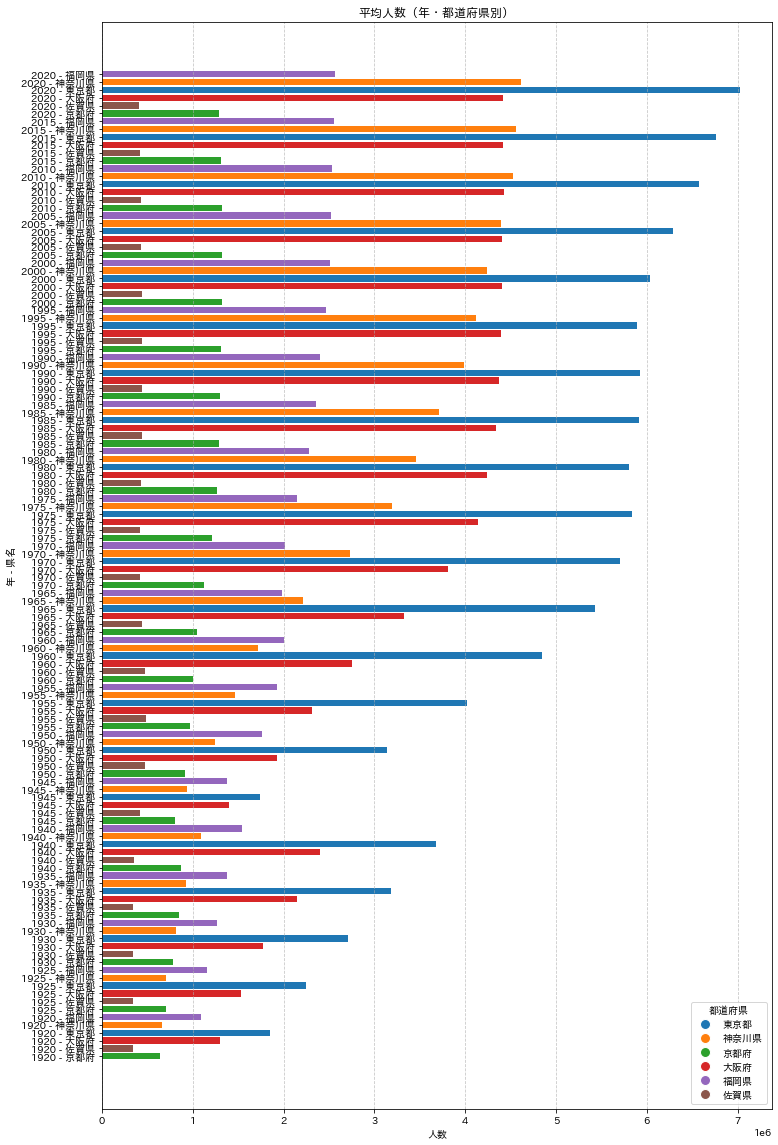

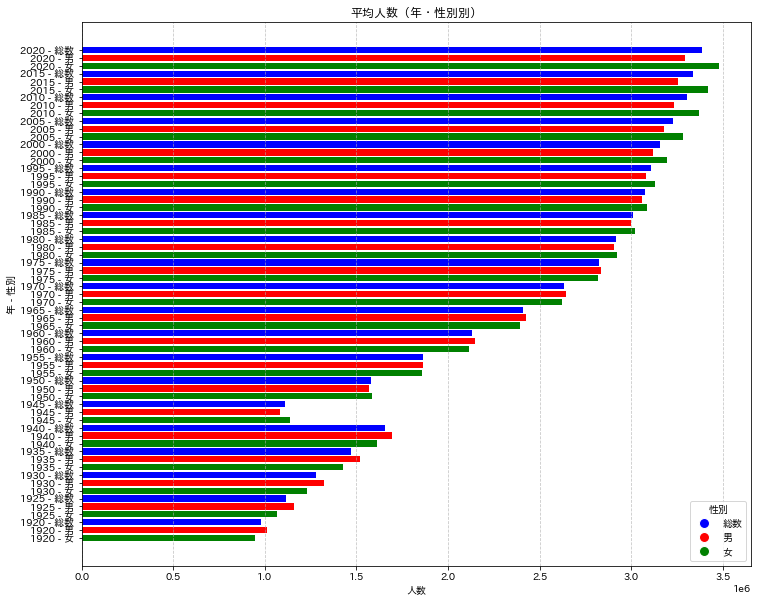

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm

# フォント設定（日本語対応）
plt.rcParams["font.family"] = "IPAexGothic"  # 'MS Gothic' なども可

# 県ごとの色を割り当てる（カラーマップ作成）
area_list = final_df["県名"].astype(str).unique()
colors = list(mcolors.TABLEAU_COLORS.values())[:len(area_list)]
area_colors = {area: color for area, color in zip(area_list, colors)}

# 性別ごとの色を割り当てる
sex_list = final_df["性別"].astype(str).unique()
sex_colors = {sex: color for sex, color in zip(sex_list, ["blue", "red", "green"])}  # 適宜追加

# 各都道府県・年ごとの平均人数
area_year_avg = final_df.groupby(["年", "県名"])["人数"].mean().sort_index(level="年", ascending=True)

# 各性別・年ごとの平均人数
sex_year_avg = final_df.groupby(["年", "性別"])["人数"].mean().sort_index(level="年", ascending=True)

# --- 1つ目のグラフ（都道府県別） ---
plt.figure(figsize=(12, 20))
plt.barh(
    [f"{year} - {area}" for year, area in area_year_avg.index],
    area_year_avg.values,
    color=[area_colors[area] for _, area in area_year_avg.index]
)

# 凡例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=area) for area, color in area_colors.items()]
plt.legend(handles=handles, title="都道府県")
plt.xlabel("人数")
plt.ylabel("年 - 県名")
plt.title("平均人数（年・都道府県別）")
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()

# --- 2つ目のグラフ（性別別） ---
plt.figure(figsize=(12, 10))
plt.barh(
    [f"{year} - {sex}" for year, sex in sex_year_avg.index],
    sex_year_avg.values,
    color=[sex_colors[sex] for _, sex in sex_year_avg.index]
)

# 凡例
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sex) for sex, color in sex_colors.items()]
plt.legend(handles=handles, title="性別")
plt.xlabel("人数")
plt.ylabel("年 - 性別")
plt.title("平均人数（年・性別別）")
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()
